In [17]:
import os

os.listdir("/content/fake_news_dataset")


['True.csv', 'Fake.csv']

In [18]:
import pandas as pd

fake_df = pd.read_csv("/content/fake_news_dataset/Fake.csv")
true_df = pd.read_csv("/content/fake_news_dataset/True.csv")

fake_df["label"] = 0   # Fake
true_df["label"] = 1   # Real

df = pd.concat([fake_df, true_df], axis=0).reset_index(drop=True)
df = df[["text", "label"]]

df.head()


,text,label
0,Donald Trump just couldn t wish all Americans ...,0
1,House Intelligence Committee Chairman Devin Nu...,0
2,"On Friday, it was revealed that former Milwauk...",0
3,"On Christmas day, Donald Trump announced that ...",0
4,Pope Francis used his annual Christmas Day mes...,0


In [19]:
from sklearn.model_selection import train_test_split

train_texts, test_texts, train_labels, test_labels = train_test_split(
    df["text"].tolist(),
    df["label"].tolist(),
    test_size=0.2,
    random_state=42,
    stratify=df["label"]
)


In [20]:
from transformers import RobertaTokenizer

tokenizer = RobertaTokenizer.from_pretrained("roberta-base")


In [21]:
train_encodings = tokenizer(
    train_texts,
    truncation=True,
    padding=True,
    max_length=256
)

test_encodings = tokenizer(
    test_texts,
    truncation=True,
    padding=True,
    max_length=256
)


In [22]:
from datasets import Dataset

train_dataset = Dataset.from_dict({
    "input_ids": train_encodings["input_ids"],
    "attention_mask": train_encodings["attention_mask"],
    "labels": train_labels
})

test_dataset = Dataset.from_dict({
    "input_ids": test_encodings["input_ids"],
    "attention_mask": test_encodings["attention_mask"],
    "labels": test_labels
})


In [23]:
from transformers import RobertaForSequenceClassification

model = RobertaForSequenceClassification.from_pretrained(
    "roberta-base",
    num_labels=2
)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [24]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)

    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, preds, average="binary"
    )
    acc = accuracy_score(labels, preds)

    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }


In [25]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    learning_rate=2e-5,
    weight_decay=0.01,
    save_strategy="no",
    logging_steps=100,
    report_to="none"
)


In [26]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)


In [27]:
trainer.train()


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.000000,0.002814,0.999555,1.000000,0.999066,0.999533
2,0.000000,0.000011,1.000000,1.000000,1.000000,1.000000
3,0.000000,0.000002,1.000000,1.000000,1.000000,1.000000


TrainOutput(global_step=6735, training_loss=0.004538189519013786, metrics={'train_runtime': 4854.8362, 'train_samples_per_second': 22.195, 'train_steps_per_second': 1.387, 'total_flos': 1.417563432963072e+16, 'train_loss': 0.004538189519013786, 'epoch': 3.0})

In [28]:
trainer.save_model("./roberta_fake_news_model")
tokenizer.save_pretrained("./roberta_fake_news_model")


('./roberta_fake_news_model/tokenizer_config.json',
 './roberta_fake_news_model/special_tokens_map.json',
 './roberta_fake_news_model/vocab.json',
 './roberta_fake_news_model/merges.txt',
 './roberta_fake_news_model/added_tokens.json')

In [29]:
eval_results = trainer.evaluate()
eval_results


{'eval_loss': 1.9142096334689995e-06,
 'eval_accuracy': 1.0,
 'eval_precision': 1.0,
 'eval_recall': 1.0,
 'eval_f1': 1.0,
 'eval_runtime': 113.4545,
 'eval_samples_per_second': 79.151,
 'eval_steps_per_second': 4.954,
 'epoch': 3.0}

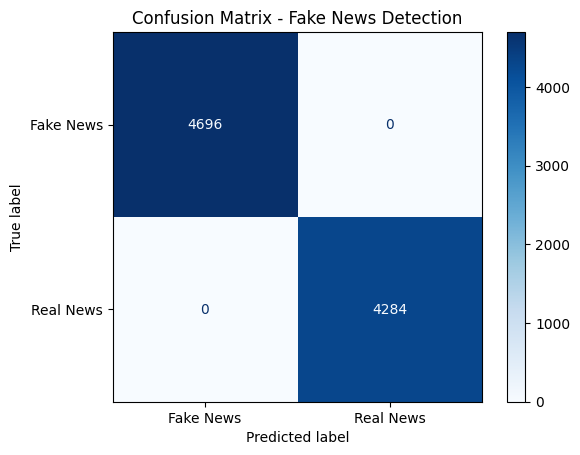

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

predictions = trainer.predict(trainer.eval_dataset)

y_pred = np.argmax(predictions.predictions, axis=1)
y_true = predictions.label_ids

cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["Fake News", "Real News"]
)

disp.plot(cmap="Blues")
plt.title("Confusion Matrix - Fake News Detection")
plt.show()


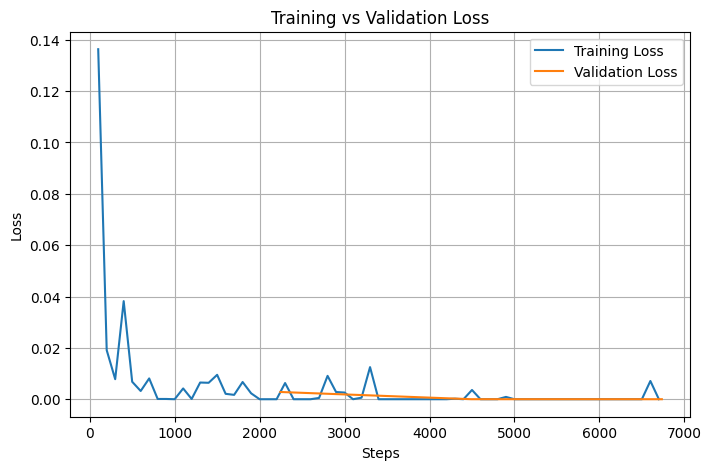

In [33]:
import pandas as pd
import matplotlib.pyplot as plt

logs = trainer.state.log_history
df = pd.DataFrame(logs)

train_loss = df[df["loss"].notna()][["step", "loss"]]
eval_loss = df[df["eval_loss"].notna()][["step", "eval_loss"]]

plt.figure(figsize=(8,5))
plt.plot(train_loss["step"], train_loss["loss"], label="Training Loss")
plt.plot(eval_loss["step"], eval_loss["eval_loss"], label="Validation Loss")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid()
plt.show()


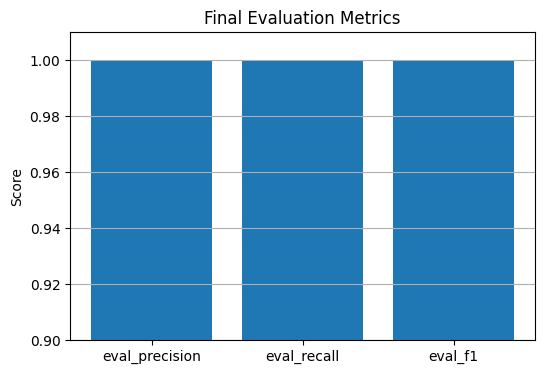

In [34]:
metrics = df[df["eval_precision"].notna()][
    ["eval_precision", "eval_recall", "eval_f1"]
].iloc[-1]

plt.figure(figsize=(6,4))
plt.bar(metrics.index, metrics.values)
plt.ylabel("Score")
plt.title("Final Evaluation Metrics")
plt.ylim(0.9, 1.01)
plt.grid(axis="y")
plt.show()


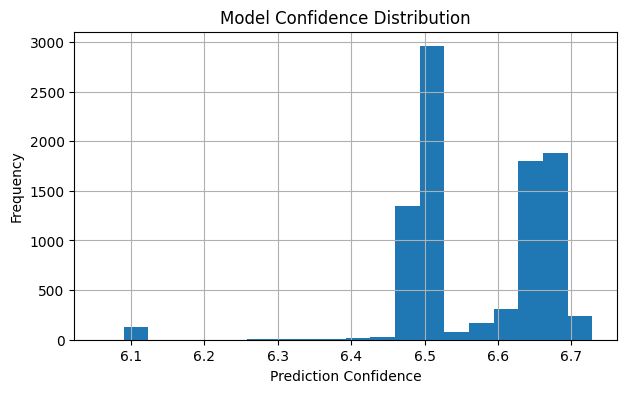

In [35]:
probs = np.max(predictions.predictions, axis=1)

plt.figure(figsize=(7,4))
plt.hist(probs, bins=20)
plt.xlabel("Prediction Confidence")
plt.ylabel("Frequency")
plt.title("Model Confidence Distribution")
plt.grid()
plt.show()
